## Benchmark: LandmarkTriangulation vs t-SNE

Compares different landmark selection strategies on synthetic clustered data.

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Add 'src' to path for development (not needed if installed via pip/uv)
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, "..", "src"))

if src_path not in sys.path:
    sys.path.insert(0, src_path)

from landmark_triangulation import LandmarkTriangulation

print("✓ All imports successful")

✓ All imports successful


In [2]:
def generate_synthetic_data(n_samples=5000, n_features=50, n_clusters=5):
    """
    Generate high-dimensional synthetic data with distinct clusters.
    
    Returns:
        X: Feature matrix of shape (n_samples, n_features)
        y: Cluster labels of shape (n_samples,)
    """
    print(f"Generating {n_samples} samples with {n_features} features and {n_clusters} clusters...")
    
    X, y = make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=n_clusters,
        cluster_std=2.0,
        random_state=42,
    )
    return X, y


def run_method(name, model, X, y):
    """
    Run a dimensionality reduction method and compute metrics.
    
    Returns:
        Dictionary with method name, runtime, silhouette score, and embedding.
    """
    print(f"Running {name}...")
    start_time = time.time()
    
    X_embedded = model.fit_transform(X)
    duration = time.time() - start_time
    
    # Silhouette score: measures cluster separation (-1 to 1, higher is better)
    score = silhouette_score(X_embedded, y)
    
    print(f"  ✓ Finished in {duration:.2f}s | Silhouette: {score:.3f}")
    
    return {
        "Method": name,
        "Time (s)": duration,
        "Silhouette": score,
        "Embedding": X_embedded,
    }

In [3]:
# Generate synthetic dataset
X, y = generate_synthetic_data(
    n_samples=2000, 
    n_features=50, 
    n_clusters=5
)

print(f"\nData shape: {X.shape}")
print(f"Number of clusters: {len(set(y))}")

Generating 2000 samples with 50 features and 5 clusters...

Data shape: (2000, 50)
Number of clusters: 5


In [4]:
# Define methods to benchmark
methods = [
    (
        "LandmarkTriangulation (Random)",
        LandmarkTriangulation(
            n_landmarks=150, 
            landmark_mode="random", 
            random_state=42
        ),
    ),
    (
        "LandmarkTriangulation (Synthetic)",
        LandmarkTriangulation(
            n_landmarks=150, 
            landmark_mode="synthetic", 
            random_state=42
        ),
    ),
    (
        "LandmarkTriangulation (Hybrid)",
        LandmarkTriangulation(
            n_landmarks=150, 
            landmark_mode="hybrid", 
            random_state=42
        ),
    ),
    (
        "t-SNE (Baseline)",
        TSNE(
            n_components=2, 
            init="pca", 
            learning_rate="auto", 
            random_state=42
        ),
    ),
]

print(f"Prepared {len(methods)} methods for benchmarking")

Prepared 4 methods for benchmarking


In [5]:
# Run all methods and collect results
print("\n" + "=" * 60)
print("BENCHMARK START")
print("=" * 60 + "\n")

results = []
for name, model in methods:
    res = run_method(name, model, X, y)
    results.append(res)

print("\n" + "=" * 60)
print("BENCHMARK COMPLETE")
print("=" * 60)


BENCHMARK START

Running LandmarkTriangulation (Random)...
  ✓ Finished in 0.15s | Silhouette: 0.807
Running LandmarkTriangulation (Synthetic)...
  ✓ Finished in 0.19s | Silhouette: 0.338
Running LandmarkTriangulation (Hybrid)...
  ✓ Finished in 0.20s | Silhouette: 0.422
Running t-SNE (Baseline)...
  ✓ Finished in 12.34s | Silhouette: 0.838

BENCHMARK COMPLETE


In [6]:
# Create summary table
df_results = pd.DataFrame(results)[["Method", "Time (s)", "Silhouette"]]

print("\n" + "=" * 60)
print("RESULTS SUMMARY")
print("=" * 60)
print(df_results.to_string(index=False))
print("=" * 60)

# Highlight fastest and best quality
fastest = df_results.loc[df_results["Time (s)"].idxmin()]
best_quality = df_results.loc[df_results["Silhouette"].idxmax()]

print(f"\n⚡ Fastest: {fastest['Method']} ({fastest['Time (s)']:.2f}s)")
print(f"🎯 Best Quality: {best_quality['Method']} (Silhouette: {best_quality['Silhouette']:.3f})")


RESULTS SUMMARY
                           Method  Time (s)  Silhouette
   LandmarkTriangulation (Random)  0.289144    0.806795
LandmarkTriangulation (Synthetic)  0.169592    0.337700
   LandmarkTriangulation (Hybrid)  0.209688    0.611236
                 t-SNE (Baseline) 12.098395    0.838264

⚡ Fastest: LandmarkTriangulation (Synthetic) (0.17s)
🎯 Best Quality: t-SNE (Baseline) (Silhouette: 0.838)


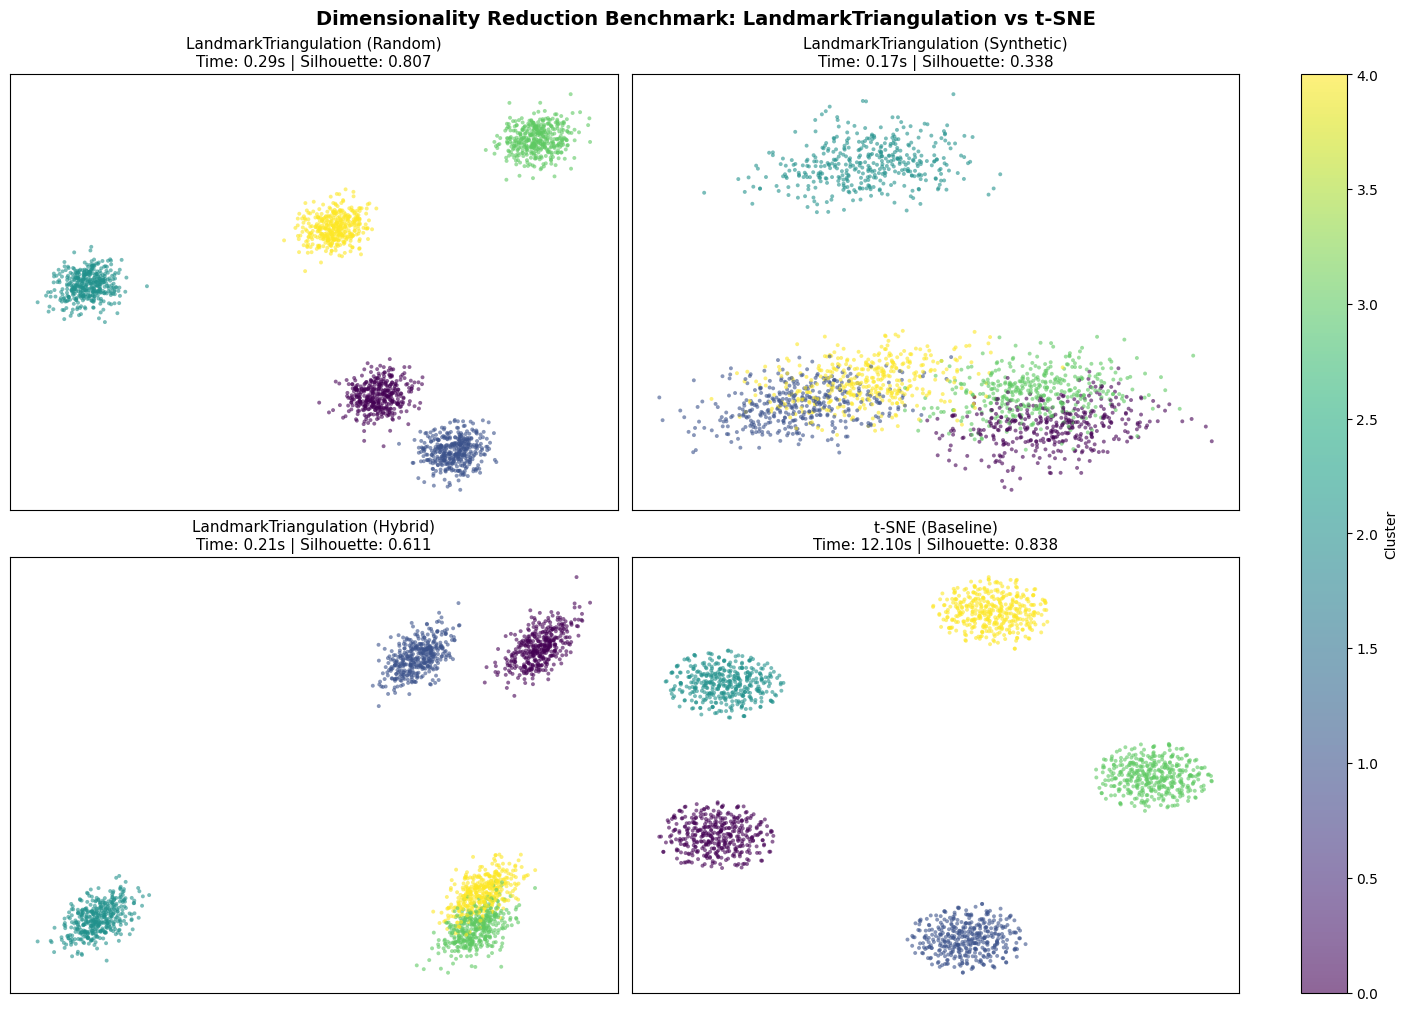

In [7]:
# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
axes = axes.flatten()

for i, res in enumerate(results):
    ax = axes[i]
    emb = res["Embedding"]

    scatter = ax.scatter(
        emb[:, 0],
        emb[:, 1],
        c=y,
        cmap="viridis",
        alpha=0.6,
        s=8,
        edgecolors="none",
    )

    ax.set_title(
        f"{res['Method']}\n"
        f"Time: {res['Time (s)']:.2f}s | Silhouette: {res['Silhouette']:.3f}",
        fontsize=11,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.2, linestyle="--")

# Add a single colorbar for the whole figure
fig.colorbar(scatter, ax=axes.ravel().tolist(), label="Cluster")

fig.suptitle(
    "Dimensionality Reduction Benchmark: LandmarkTriangulation vs t-SNE",
    fontsize=14,
    fontweight="bold",
)

plt.show()